# Multiple Linear Regression (MLR) Model
This model is included in this project as a baseline machine learning model before exploring more complex options, such as neural networks and deep learning architectures. 

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings

# Torch required packages
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


Load data

In [2]:
south_central_wz = pq.read_table(f"data/south_central_wz.parquet").to_pandas()

In [3]:
lim = south_central_wz[[
    'YEAR', 'MONTH', 'DAY', 'HOUR_ENDING', 
    'SOUTH_C',
    'DRY_BULB_TEMPERATURE_KAUS', 
    'RELATIVE_HUMIDITY_KAUS', 
    'DRY_BULB_TEMPERATURE_KSAT', 
    'RELATIVE_HUMIDITY_KSAT',
]]
for str_issue_col in [
    'DRY_BULB_TEMPERATURE_KAUS', 
    'RELATIVE_HUMIDITY_KAUS', 
    'DRY_BULB_TEMPERATURE_KSAT', 
    'RELATIVE_HUMIDITY_KSAT'
]:
    with pd.option_context('mode.chained_assignment', None):
        lim[str_issue_col] = [_.replace('s', '') if isinstance(_, str) else _ for _ in lim[str_issue_col]]
        lim.loc[lim[str_issue_col] == '*', str_issue_col] = None
        lim[str_issue_col] = lim[str_issue_col].astype('float')

In [4]:
lim.isna().sum()

YEAR                             0
MONTH                            0
DAY                              0
HOUR_ENDING                      0
SOUTH_C                      52512
DRY_BULB_TEMPERATURE_KAUS        4
RELATIVE_HUMIDITY_KAUS          11
DRY_BULB_TEMPERATURE_KSAT        3
RELATIVE_HUMIDITY_KSAT           6
dtype: int64

In [5]:
lim_datetime = lim.copy()
lim_datetime['DATETIME'] = [
    datetime(int(row['YEAR']), int(row['MONTH']), int(row['DAY']), int(row['HOUR_ENDING'] - 1))  # hour cannot be 24 
    for i, row in lim_datetime.iterrows()
]
lim_datetime = lim_datetime[[_ for _ in lim_datetime.columns if _ not in ['YEAR', 'MONTH', 'DAY', 'HOUR_ENDING']]]
lim_datetime.dropna(how='any', inplace=True)

Text(0.5, 1.0, 'Load')

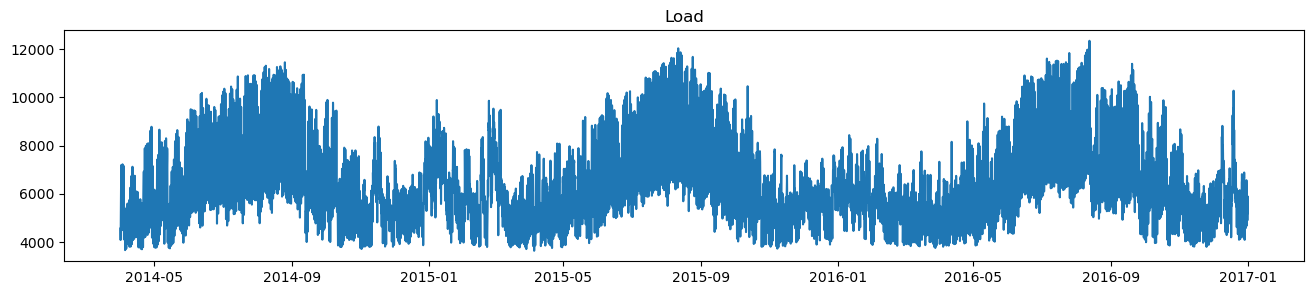

In [6]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(lim_datetime['DATETIME'], lim_datetime['SOUTH_C'])
ax.set_title(label='Load')

Text(0.5, 1.0, 'Temperature')

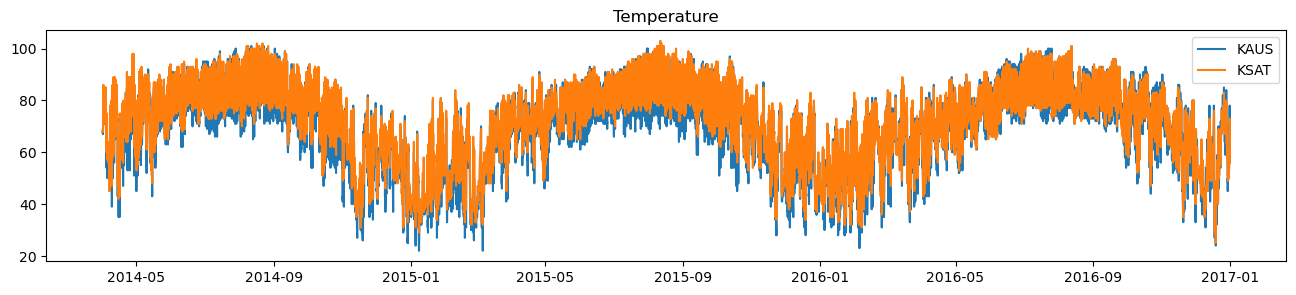

In [7]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(lim_datetime['DATETIME'], lim_datetime['DRY_BULB_TEMPERATURE_KAUS'], label='KAUS')
ax.plot(lim_datetime['DATETIME'], lim_datetime['DRY_BULB_TEMPERATURE_KSAT'], label='KSAT')
ax.legend()
ax.set_title(label='Temperature')

Text(0.5, 1.0, 'Relative Humidity')

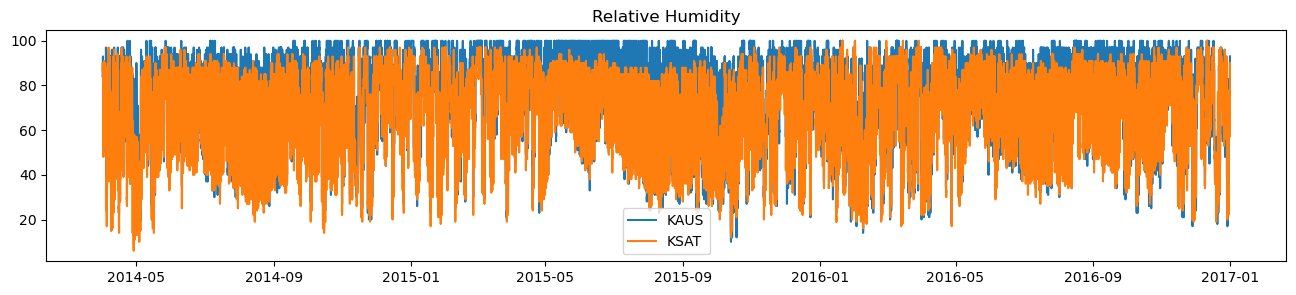

In [8]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(lim_datetime['DATETIME'], lim_datetime['RELATIVE_HUMIDITY_KAUS'], label='KAUS')
ax.plot(lim_datetime['DATETIME'], lim_datetime['RELATIVE_HUMIDITY_KSAT'], label='KSAT')
ax.legend()
ax.set_title(label='Relative Humidity')

In [9]:
# TODO: check data load process to see if this limiation can be avoided
lim = lim.dropna(how='any')
with pd.option_context('mode.chained_assignment', None):
    datetime_ref = [
        datetime(int(row['YEAR']), int(row['MONTH']), int(row['DAY']), int(row['HOUR_ENDING'] - 1))  # hour cannot be 24 
        for i, row in lim.iterrows()
    ]

In [10]:
cols = lim.columns.tolist()
features = cols[0:4] + cols[5:]

X = lim[features]
y = lim[["SOUTH_C"]]

In [11]:
features

['YEAR',
 'MONTH',
 'DAY',
 'HOUR_ENDING',
 'DRY_BULB_TEMPERATURE_KAUS',
 'RELATIVE_HUMIDITY_KAUS',
 'DRY_BULB_TEMPERATURE_KSAT',
 'RELATIVE_HUMIDITY_KSAT']

In [42]:
lim_datetime

,SOUTH_C,DRY_BULB_TEMPERATURE_KAUS,RELATIVE_HUMIDITY_KAUS,DRY_BULB_TEMPERATURE_KSAT,RELATIVE_HUMIDITY_KSAT,DATETIME
0,4559.489573,68.0,84.0,68.0,87.0,2014-04-01 00:00:00
1,4298.344445,68.0,84.0,68.0,90.0,2014-04-01 01:00:00
2,4143.337860,68.0,87.0,69.0,87.0,2014-04-01 02:00:00
3,4083.663654,67.0,91.0,69.0,87.0,2014-04-01 03:00:00
4,4137.650637,67.0,93.0,69.0,84.0,2014-04-01 04:00:00
...,...,...,...,...,...,...
23120,5898.486322,67.0,79.0,65.0,70.0,2016-12-31 18:00:00
23121,5712.730175,65.0,84.0,62.0,75.0,2016-12-31 19:00:00
23122,5423.515665,63.0,87.0,60.0,80.0,2016-12-31 20:00:00
23123,5172.592743,60.0,90.0,59.0,83.0,2016-12-31 21:00:00


In [43]:
prophet_data = lim_datetime[["DATETIME", "SOUTH_C"]]

rename = {
    "DATETIME": "ds",
    "SOUTH_C": "y"
}

prophet_data = prophet_data.rename(columns = rename)
prophet_data

,ds,y
0,2014-04-01 00:00:00,4559.489573
1,2014-04-01 01:00:00,4298.344445
2,2014-04-01 02:00:00,4143.337860
3,2014-04-01 03:00:00,4083.663654
4,2014-04-01 04:00:00,4137.650637
...,...,...
23120,2016-12-31 18:00:00,5898.486322
23121,2016-12-31 19:00:00,5712.730175
23122,2016-12-31 20:00:00,5423.515665
23123,2016-12-31 21:00:00,5172.592743


In [45]:
train, test = train_test_split(
    prophet_data,
    test_size = 0.1
)

In [46]:
m = Prophet()
forecast = m.fit(train)

12:36:12 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
forecast = m.predict(train)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
20803,2016-12-31 18:00:00,7208.739406,6096.102187,8325.827964
20804,2016-12-31 19:00:00,7123.860911,6026.134251,8342.815405
20805,2016-12-31 20:00:00,6900.221198,5749.237090,8053.440414
20806,2016-12-31 21:00:00,6531.313602,5399.161070,7686.757795
20807,2016-12-31 22:00:00,6052.839150,4892.992959,7182.834438


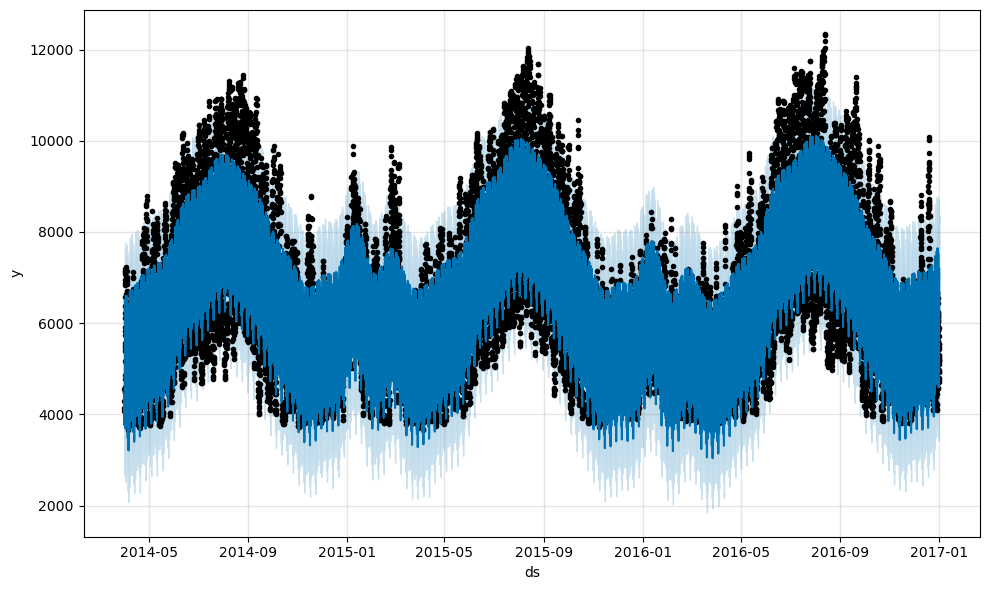

In [48]:
fig1 = m.plot(forecast)

In [49]:
validation = train.copy()
validation["yhat"] = forecast["yhat"]

In [51]:
validation["Squared_Error"] = (validation["y"] - validation["yhat"]) * (validation["y"] - validation["yhat"])
rmse_train = np.sqrt(validation["Squared_Error"].mean())

print("Training RMSE", rmse_train)

Training RMSE 2148.061021846296


## On Testing Set

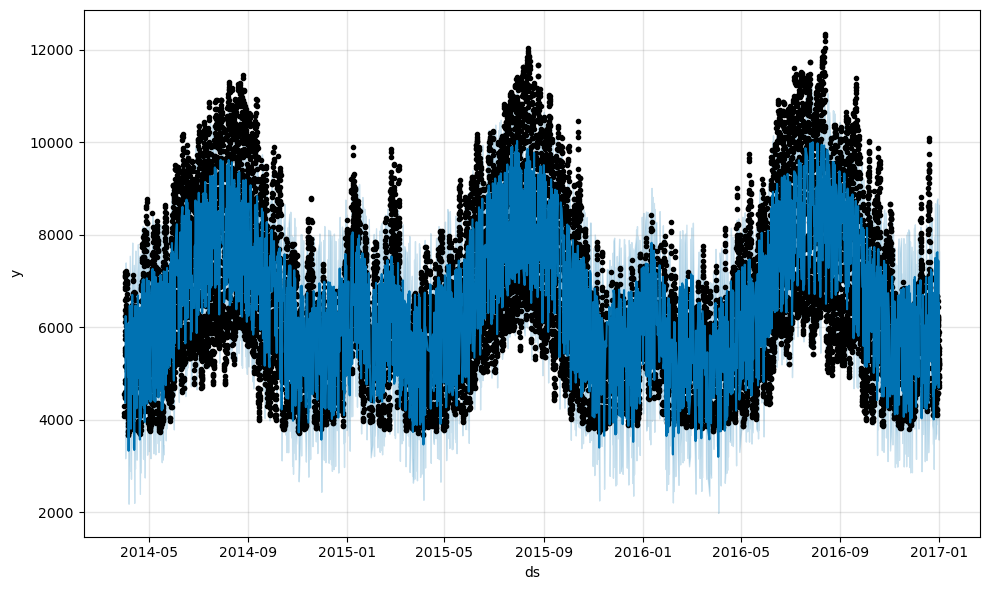

In [52]:
forecast_test = m.predict(test)
fig2 = m.plot(forecast_test)

In [53]:
testing = test.copy()
testing["yhat"] = forecast_test["yhat"]

In [54]:
testing["Squared_Error"] = (testing["y"] - testing["yhat"]) * (testing["y"] - testing["yhat"])
rmse_train = np.sqrt(testing["Squared_Error"].mean())

print("Testing RMSE", rmse_train)

Testing RMSE 2404.559519422706
